# 7.2  RNN手写字体识别




In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
## 设置图像风格
import seaborn as sns
sns.set(font_scale=1.5,style="white") 

In [1]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optimdd
import torchvision
import torch.utils.data as Data
from torchvision import transforms

In [23]:
import hiddenlayer as hl

### 数据准备

In [4]:
## 准备训练数据集Minist
train_data  = torchvision.datasets.MNIST(
    root = "./data/MNIST", # 数据的路径
    train = True, # 只使用训练数据集
    # 将数据转化为torch使用的张量,取汁范围为［0，1］
    transform  = transforms.ToTensor(),
    download= True # 因为数据已经下载过，所以这里不再下载
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [5]:
## 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 2, # 使用两个进程 
)

##  可视化训练数据集的一个batch的样本来查看图像内容
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸，都是torch格式的数据
print(b_x.shape)
print(b_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
## 准备需要使用的测试数据集
test_data  = torchvision.datasets.MNIST(
    root = "./data/MNIST", # 数据的路径
    train = False, # 不使用训练数据集
    transform  = transforms.ToTensor(),
    download= False # 因为数据已经下载过，所以这里不再下载
)
## 定义一个数据加载器
test_loader = Data.DataLoader(
    dataset = test_data, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 2, # 使用两个进程 
)
##  可视化训练数据集的一个batch的样本来查看图像内容
for step, (b_x, b_y) in enumerate(test_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸，都是torch格式的数据
print(b_x.shape)
print(b_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


### 搭建RNN模型

In [7]:
class RNNimc(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        """
        input_dim:输入数据的维度(图片每行的数据像素点)
        hidden_dim: RNN神经元个数
        layer_dim: RNN的层数
        output_dim:隐藏层输出的维度(分类的数量)
        """
        super(RNNimc, self).__init__()
        self.hidden_dim = hidden_dim ## RNN神经元个数
        self.layer_dim = layer_dim ## RNN的层数
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim,
                          batch_first=True, nonlinearity='relu')
        
        # 连接全连阶层
        self.fc1 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        # x:[batch, time_step, input_dim]
        # 本例中time_step＝图像所有像素数量／input_dim
        # out:[batch, time_step, output_size]
        # h_n:[layer_dim, batch, hidden_dim]
        out, h_n = self.rnn(x, None) # None表示h0会使用全0进行初始化
        # 选取最后一个时间点的out输出
        out = self.fc1(out[:, -1, :]) 
        return out
    

In [8]:
## 模型的调用
input_dim=28   # 图片每行的像素数量
hidden_dim=128  # RNN神经元个数
layer_dim = 1  # RNN的层数
output_dim=10  # 隐藏层输出的维度(10类图像)
MyRNNimc = RNNimc(input_dim, hidden_dim, layer_dim, output_dim)
print(MyRNNimc)

RNNimc(
  (rnn): RNN(28, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
from graphviz import Digraph

In [22]:
Digraph?

Init signature:
Digraph(
    name: Optional[str] = None,
    comment: Optional[str] = None,
    filename=None,
    directory=None,
    format: Optional[str] = None,
    engine: Optional[str] = None,
    encoding: Optional[str] = 'utf-8',
    graph_attr=None,
    node_attr=None,
    edge_attr=None,
    body=None,
    strict: bool = False,
    *,
    renderer: Optional[str] = None,
    formatter: Optional[str] = None,
) -> None
Docstring:     
Directed graph source code in the DOT language.

Args:
    name: Graph name used in the source code.
    comment: Comment added to the first line of the source.
    filename: Filename for saving the source
        (defaults to ``name`` + ``'.gv'``).
    directory: (Sub)directory for source saving and rendering.
    format: Rendering output format (``'pdf'``, ``'png'``, ...).
    engine: Layout command used (``'dot'``, ``'neato'``, ...).
    renderer: Output renderer used (``'cairo'``, ``'gd'``, ...).
    formatter: Output formatter used (``'cairo'`

In [25]:
## 可视化卷积神经网络
## 输入:[batch, time_step, input_dim]
hl_graph = hl.build_graph(MyRNNimc, torch.zeros([1, 28, 28]))

In [26]:
hl_graph.theme = hl.graph.THEMES["blue"].copy()  

In [33]:
## 将可视化的网路保存为图片,默认格式为pdf
hl_graph.save("./MyRNNimc_hl")

### 对模型进行训练

In [34]:
## 对模型进行训练
optimizer = torch.optim.RMSprop(MyRNNimc.parameters(), lr=0.0003)  
criterion = nn.CrossEntropyLoss()   # 损失函数
train_loss_all = []
train_acc_all = []
test_loss_all = []
test_acc_all = []
num_epochs = 30
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    MyRNNimc.train() ## 设置模型为训练模式
    corrects = 0
    train_num  = 0
    for step,(b_x, b_y) in enumerate(train_loader):
        # input :[batch, time_step, input_dim]
        xdata = b_x.view(-1, 28, 28)
        output = MyRNNimc(xdata)     
        pre_lab = torch.argmax(output,1)
        loss = criterion(output, b_y) 
        optimizer.zero_grad()        
        loss.backward()       
        optimizer.step()  
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum(pre_lab == b_y.data)
        train_num += b_x.size(0)
    ## 计算经过一个epoch的训练后在训练集上的损失和精度
    train_loss_all.append(loss / train_num)
    train_acc_all.append(corrects.double().item()/train_num)
    print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
        epoch, train_loss_all[-1], train_acc_all[-1]))
    ## 设置模型为验证模式
    MyRNNimc.eval()
    corrects = 0
    test_num  = 0
    for step,(b_x, b_y) in enumerate(test_loader):
        # input :[batch, time_step, input_dim]
        xdata = b_x.view(-1, 28, 28)
        output = MyRNNimc(xdata)     
        pre_lab = torch.argmax(output,1)
        loss = criterion(output, b_y) 
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum(pre_lab == b_y.data)
        test_num += b_x.size(0)
    ## 计算经过一个epoch的训练后在测试集上的损失和精度
    test_loss_all.append(loss / test_num)
    test_acc_all.append(corrects.double().item()/test_num)
    print('{} Test Loss: {:.4f}  Test Acc: {:.4f}'.format(
        epoch, test_loss_all[-1], test_acc_all[-1]))


Epoch 0/29
0 Train Loss: 0.0004  Train Acc: 0.6535
0 Test Loss: 0.0006  Test Acc: 0.7410
Epoch 1/29
1 Train Loss: 0.0001  Train Acc: 0.8209
1 Test Loss: 0.0016  Test Acc: 0.8709
Epoch 2/29
2 Train Loss: 0.0002  Train Acc: 0.8772
2 Test Loss: 0.0006  Test Acc: 0.8960
Epoch 3/29
3 Train Loss: 0.0000  Train Acc: 0.9099
3 Test Loss: 0.0007  Test Acc: 0.9253
Epoch 4/29
4 Train Loss: 0.0001  Train Acc: 0.9286
4 Test Loss: 0.0009  Test Acc: 0.9162
Epoch 5/29
5 Train Loss: 0.0001  Train Acc: 0.9383
5 Test Loss: 0.0004  Test Acc: 0.9147
Epoch 6/29
6 Train Loss: 0.0001  Train Acc: 0.9473
6 Test Loss: 0.0004  Test Acc: 0.9511
Epoch 7/29
7 Train Loss: 0.0001  Train Acc: 0.9528
7 Test Loss: 0.0003  Test Acc: 0.9385
Epoch 8/29
8 Train Loss: 0.0000  Train Acc: 0.9573
8 Test Loss: 0.0001  Test Acc: 0.9577
Epoch 9/29
9 Train Loss: 0.0001  Train Acc: 0.9601
9 Test Loss: 0.0001  Test Acc: 0.9285
Epoch 10/29
10 Train Loss: 0.0001  Train Acc: 0.9638
10 Test Loss: 0.0000  Test Acc: 0.9655
Epoch 11/29
11 Tra

In [49]:
train_loss_all

[tensor(0.0004, grad_fn=<DivBackward0>),
 tensor(8.1374e-05, grad_fn=<DivBackward0>),
 tensor(0.0002, grad_fn=<DivBackward0>),
 tensor(2.4539e-05, grad_fn=<DivBackward0>),
 tensor(0.0001, grad_fn=<DivBackward0>),
 tensor(6.0534e-05, grad_fn=<DivBackward0>),
 tensor(5.0044e-05, grad_fn=<DivBackward0>),
 tensor(5.3609e-05, grad_fn=<DivBackward0>),
 tensor(4.8787e-05, grad_fn=<DivBackward0>),
 tensor(7.8450e-05, grad_fn=<DivBackward0>),
 tensor(5.3576e-05, grad_fn=<DivBackward0>),
 tensor(6.0793e-05, grad_fn=<DivBackward0>),
 tensor(1.7521e-05, grad_fn=<DivBackward0>),
 tensor(5.6502e-05, grad_fn=<DivBackward0>),
 tensor(3.1462e-06, grad_fn=<DivBackward0>),
 tensor(1.7592e-05, grad_fn=<DivBackward0>),
 tensor(0.0002, grad_fn=<DivBackward0>),
 tensor(1.1085e-05, grad_fn=<DivBackward0>),
 tensor(4.7300e-05, grad_fn=<DivBackward0>),
 tensor(0.0001, grad_fn=<DivBackward0>),
 tensor(1.0374e-06, grad_fn=<DivBackward0>),
 tensor(9.3780e-05, grad_fn=<DivBackward0>),
 tensor(9.2082e-05, grad_fn=<D

In [45]:
type(train_loss_all)

list

In [48]:
for i in train_loss_all:
    print(i.item())

0.000396895018639043
8.137449185596779e-05
0.00016285074525512755
2.453865272400435e-05
0.00013113475870341063
6.053434844943695e-05
5.004441482014954e-05
5.360853538149968e-05
4.8786692786961794e-05
7.845018262742087e-05
5.3576040954794735e-05
6.079277954995632e-05
1.75207678694278e-05
5.650208913721144e-05
3.14615317620337e-06
1.759197584760841e-05
0.00017576782556716353
1.1085125152021646e-05
4.7299756261054426e-05
0.00010442675556987524
1.0374177463745582e-06
9.378047252539545e-05
9.208195115206763e-05
3.0353407964867074e-06
0.00010964092507492751
3.466459384071641e-05
2.5407389330212027e-05
2.5456614821450785e-05
4.2045663576573133e-05
3.4374825190752745e-06


In [38]:
np.array(train_loss_all)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [44]:
x = torch.tensor(0.8806, requires_grad=True)
x

tensor(0.8806, requires_grad=True)

In [43]:
print(x.item())

0.8805999755859375


In [57]:
train_acc_all

[0.6535,
 0.8208666666666666,
 0.8772333333333333,
 0.9098666666666667,
 0.9286333333333333,
 0.9383,
 0.9472666666666667,
 0.9527833333333333,
 0.95725,
 0.9600666666666666,
 0.9637833333333333,
 0.9665666666666667,
 0.9692666666666667,
 0.9693333333333334,
 0.9716,
 0.9740833333333333,
 0.9752666666666666,
 0.97655,
 0.9782333333333333,
 0.9779166666666667,
 0.97925,
 0.97955,
 0.98095,
 0.9812333333333333,
 0.98215,
 0.98265,
 0.9834333333333334,
 0.9834166666666667,
 0.9841166666666666,
 0.98505]

In [58]:
train_loss_all_list=[]
for i in train_loss_all:
    train_loss_all_list.append(i.item())

test_loss_all_list=[]
for i in test_loss_all:
    test_loss_all_list.append(i.item())

AttributeError: 'float' object has no attribute 'item'

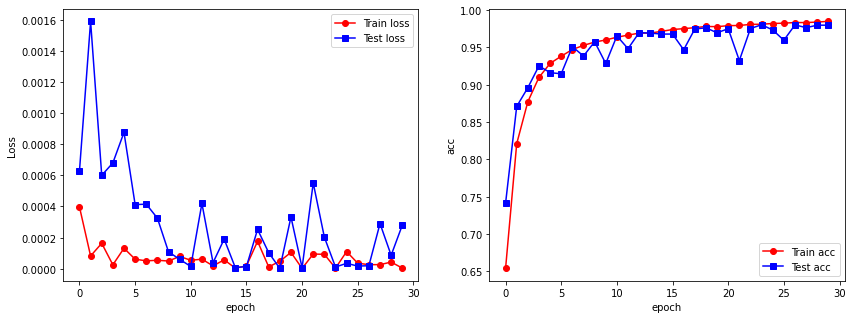

In [60]:
## 可视化模型训练过程中
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_loss_all_list,"ro-",label = "Train loss")
plt.plot(test_loss_all_list,"bs-",label = "Test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_acc_all,"ro-",label = "Train acc")
plt.plot(test_acc_all,"bs-",label = "Test acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()